# Tutorial: Analysis of Spatial Data , Pathway Visualization and Parameter sensitivity

In this tutorial, we demonstrate the usage of STT to spatial transcriptome data of developing mouse brain imputed by SIRV algorithm and show the basic usage of pathway analysis. We will also explore the sensitivity of hyperparameters in STT.

In [1]:
import stt as st
import scanpy as sc
import anndata
import scvelo as scv
import numpy as np
import pandas as pd

The processed data could be download [here](https://drive.google.com/file/d/1c53v1xo0wPd_2O7Zkfz1SWYsrv6e5bUC/view?usp=drive_link)

In [2]:
data_dir = '../data/'
adata = sc.read_h5ad(data_dir+'mouse_brain.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 4628 × 117
    obs: 'n_counts', 'Region', 'Subclass', 'leiden', 'velocity_self_transition'
    var: 'GeneName', 'mean', 'std', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'highly_variable'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_xy_loc', 'velocity_xy_loc', 'xy_loc'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

Leiden clustering based on spatial locations.

In [4]:
sc.pp.neighbors(adata, use_rep = 'xy_loc',key_added ='spatial')

In [5]:
sc.tl.leiden(adata,resolution = 0.3)

Leiden clustering based on expression level

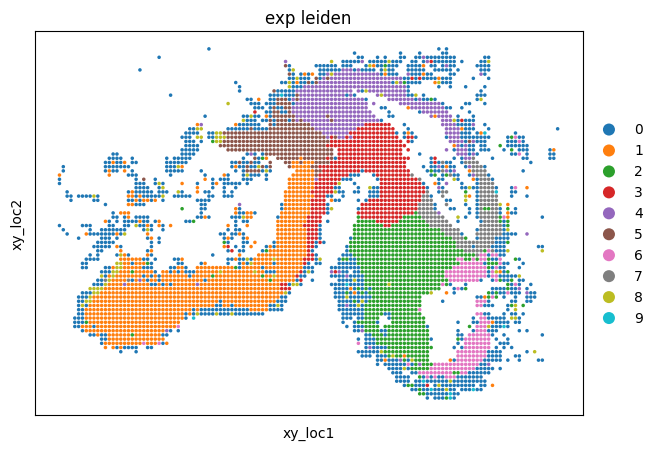

In [6]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata,resolution = 0.3,key_added = 'exp_leiden')
sc.pl.scatter(adata, basis='xy_loc', color='exp_leiden')

In [7]:
U = adata.layers['unspliced']
S = adata.layers['spliced']
if 'toarray' in dir(U):
    U = U.toarray()
    S = S.toarray()
X_all = np.concatenate((U,S),axis = 1)
adata_aggr = anndata.AnnData(X=X_all)
sc.tl.pca(adata_aggr, svd_solver='arpack')
sc.pp.neighbors(adata_aggr)

In [8]:
sc.tl.leiden(adata_aggr,resolution = 0.15)
adata.obs['joint_leiden'] = adata_aggr.obs['leiden'].values

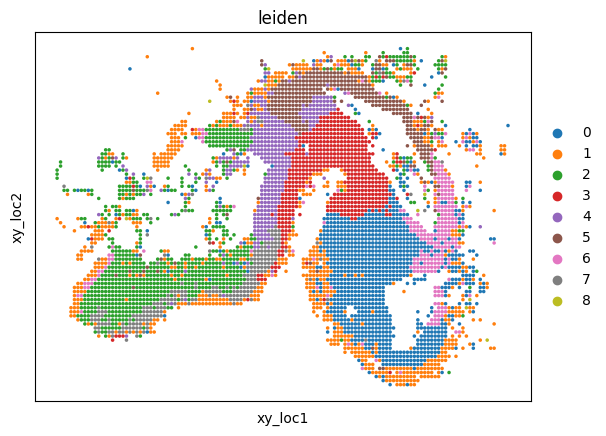

In [9]:
adata_aggr.obsm['xy_loc'] = adata.obsm['xy_loc']
sc.pl.embedding(adata_aggr, basis='xy_loc', color='leiden')

## STT dynamical analysis

To analyze spatial data, a key parameter is called `spa_weight`, which controls the relative weight of spatial location similarity kernel.

In [10]:
# Initialize attractor assignment by region annotation
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3)

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000047e+00 2.4831054436749721e-02 -1.7756018087573024e-03 2.3657390960551295e-02 -2.2033536194652790e-02 6.9996242894248334e-03 -3.5394505418927980e-03 -3.6814826653714782e-03 3.5815619230925168e-02 -8.9081962491081006e-03 -1.9690108158490347e-02 3.9554038369716575e-03 -5.5300566789580861e-03 -5.4571288343826692e-03 9.0436821307151895e-03 8.8535613259631465e-03 -1.4356950629728544e-02 -6.9938898940173954e-03 5.3617024493085325e-03 -2.5244578225417404e-02 
0.0000000000000000e+00 9.1886345758917576e-01 -4.9514399251176207e-03 -1.6433507448796480e-03 -1.0230970416201489e-02 -1.6462171332775440e-02 7.6129879932412196e-04 3.4252656083669304e-03 3.9678921723153631e-03 -8.5801617324911955e-03 -1.8928510927727405e-03 3.9882486418747363e-04 -1.4095972628092710e-02 -1.7707882269983710e-02 9.2902831987466802e-04 -6.3720258814771392e-04 4.3356743865845286e-03 6.9768218367946356e-03 1.5287972234280890e-02 2.0368733827699489e-02 
0.00000000000

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


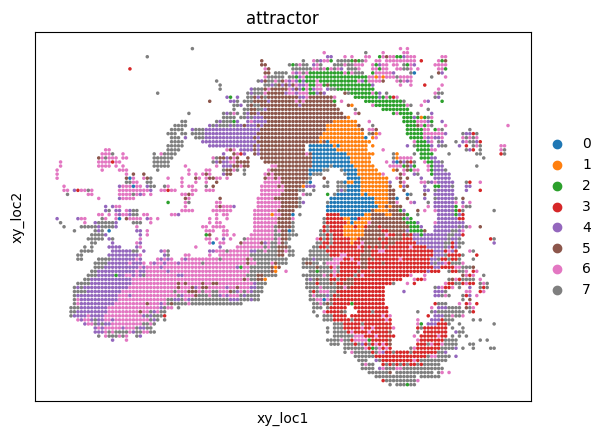

In [11]:
sc.pl.embedding(adata, basis="xy_loc", color=["attractor"])

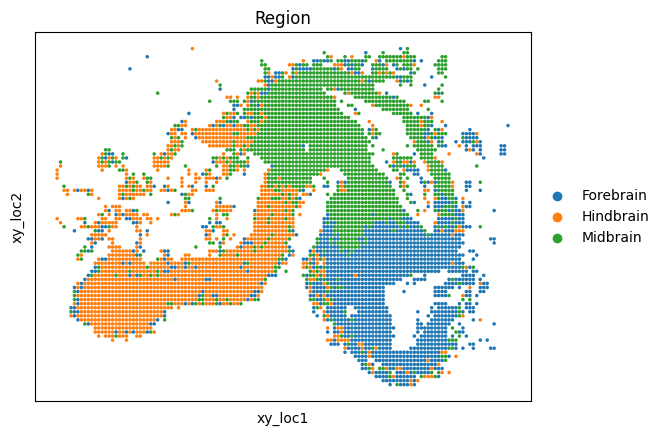

In [12]:
sc.pl.embedding(adata, basis="xy_loc", color=["Region"])

## Pathway Analysis

The `st.tl.compute_pathway` function provides the option to 

In [13]:
st.tl.compute_pathway(adata,adata_aggr,'KEGG_2019_Mouse')

computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)


After running the function, we can use the `st.pl.plot_pathway` function to visualize the similairty between pathway dynamics in the low dimensional embeddings.

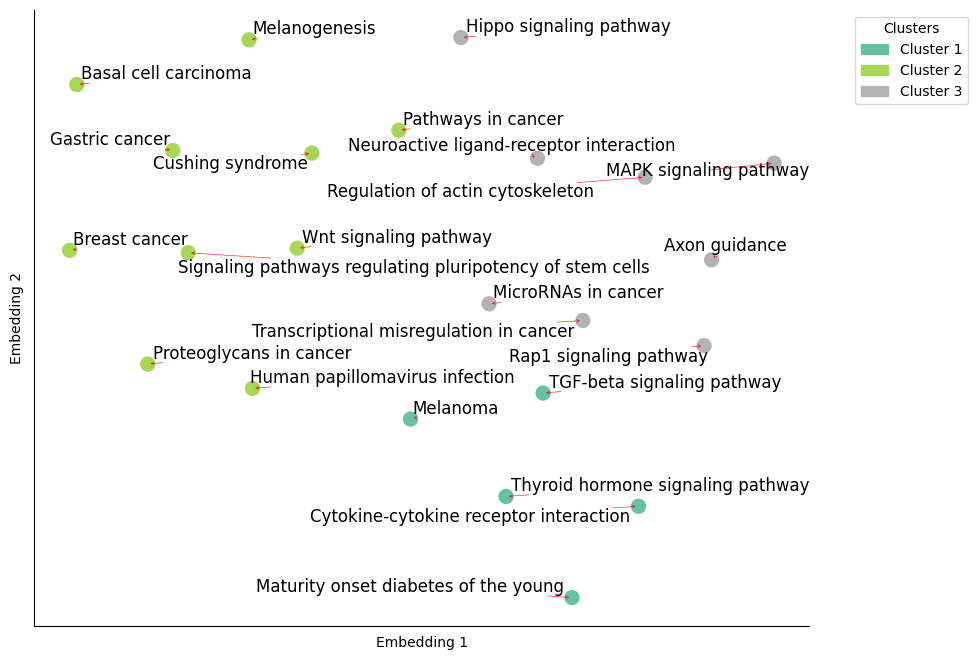

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


In [14]:
fig = st.pl.plot_pathway(adata,figsize = (10,8),size = 100,fontsize = 12)
for ax in fig.axes:
    ax.set_xlabel('Embedding 1', fontsize=20)  # Adjust font size as needed
    ax.set_ylabel('Embedding 2', fontsize=20)  # Adjust font size as needed
fig.show()

In [15]:
fig.savefig('pathway_embedding.png', bbox_inches='tight') 

If we are interested in the specific pathways, we can use the `pl.plot_tensor_pathway` function to visualize the streamlines.

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


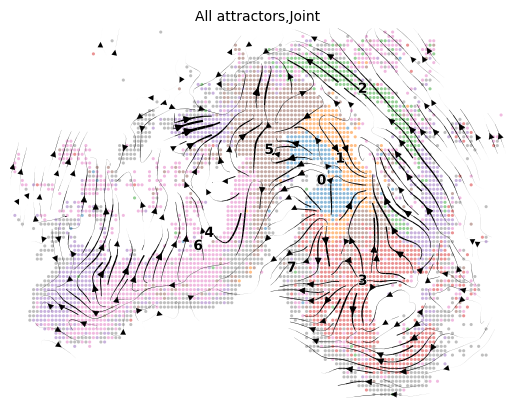

In [16]:
adata.obsm['X_xy_loc'] = adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
adata.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
st.pl.plot_tensor_pathway(adata,adata_aggr, pathway_name = 'Wnt signaling pathway',basis = 'xy_loc')

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


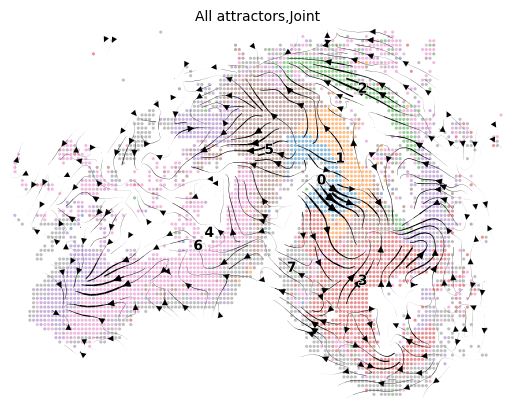

In [17]:
st.pl.plot_tensor_pathway(adata,adata_aggr, 'TGF-beta signaling pathway',basis = 'xy_loc')

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


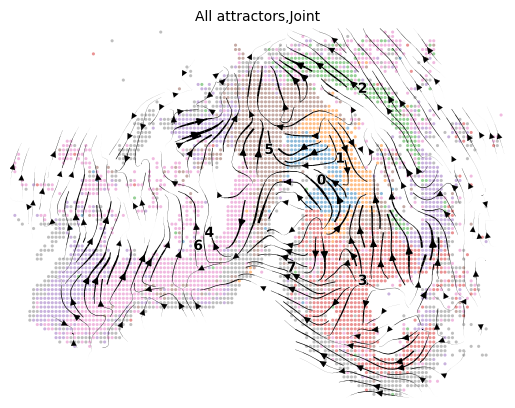

In [18]:
st.pl.plot_tensor_pathway(adata,adata_aggr, 'Hippo signaling pathway',basis = 'xy_loc')

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


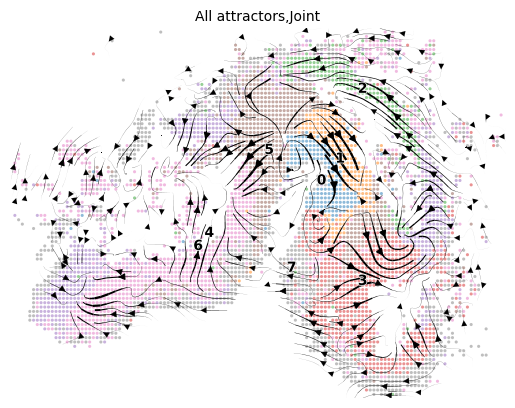

In [19]:
st.pl.plot_tensor_pathway(adata,adata_aggr, 'Thyroid hormone signaling pathway',basis = 'xy_loc')

## Sensitivity Analysis

Lastly, we explore the sensitivity of hyperparameters in STT, including `spa_weight`,`n_states`,`thresh_ms_gene`, as well as initial attractor assignment.

### Sensitivity of spatial weights

Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999656e-01 -2.3566614757941799e-02 -1.0446363712759378e-02 2.6570858848561797e-02 4.7566627081840088e-04 6.9186343679804672e-03 -1.6169928688496416e-02 2.1690705843031191e-02 2.5196318611044235e-02 2.6307038219480248e-02 9.2251751055968390e-03 4.0910671908061082e-03 -6.0898526980155566e-03 1.0453445312700090e-02 1.6338353307308900e-02 -8.6768262174463373e-03 -1.6753141243806668e-02 -1.9206003870919759e-02 1.9190890821801233e-02 -3.6292480909908546e-02 -1.2613595311133064e-02 -5.0544983412224700e-02 -2.4920051071511250e-02 
0.0000000000000000e+00 9.0976941878169237e-01 5.8438690193696194e-03 -2.5124722753557833e-03 -1.1524915998733412e-02 -1.3866554523257236e-02 6.8310272489110401e-03 4.2911372245908204e-04 3.0981572527928806e-03 -5.2988724054262373e-03 -6.7988062215312978e-03 -2.8044716793765327e-03 6.6643985643088273e-03 8.9440723736592832e-03 2.4700202206383734e-02 -9.6897920869247964e-03 4.1072109517141676e-03 -2.9918085578260

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999989e-01 2.7723869114979079e-03 -9.3892130530470914e-03 -1.9921435979894635e-02 2.6390212101047302e-02 2.8357282973751189e-03 -1.3301027132763832e-03 9.2439387046917548e-03 -6.4629366425549726e-03 -6.8284461851828831e-03 -2.9634567751596820e-02 2.0713436264478146e-04 1.2329610976190885e-02 -2.3890481714555368e-02 -1.9961716601099175e-02 2.5712836801891580e-02 1.4089728949849405e-02 -1.3523768540448285e-02 -1.1252761737173954e-02 7.3191696341485674e-03 -2.9411085386941435e-03 
0.0000000000000000e+00 9.4662163821337952e-01 1.0871391883649445e-02 -4.0704335367080305e-03 6.1638250612558359e-03 -2.3289639293925628e-03 -3.2075836360605096e-04 9.7532802036723516e-04 1.5494520684208110e-02 -7.9324713892099247e-03 -1.3358953069574585e-02 -1.7108839236773688e-02 5.3270771972173401e-03 -1.3983672611204805e-03 7.8635735536896362e-03 -1.4111234570940382e-02 -7.2581074424154348e-03 -1.3435266258310152e-02 -5.1759612476063562e-03 -2.183321903

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999878e-01 -1.7926918371299694e-03 -1.0930034134515312e-02 -1.5030763335646940e-02 2.3942392640688624e-02 4.6636965829142795e-03 -4.0934890717841009e-03 -6.8044786882620449e-04 2.6054319488305125e-03 -2.6433740109099470e-03 -1.0387169393758874e-02 1.6070342935497708e-02 2.2449546888108005e-03 1.1255648435187516e-02 2.3073526553185411e-02 1.8048336030420317e-02 -9.4886796829965619e-03 1.7428381972934767e-02 -2.8621929469469847e-03 1.8669863093554869e-03 -7.3211141199536886e-03 -2.0685220606730519e-04 -7.1356910317294901e-03 -4.3022177606491917e-03 
0.0000000000000000e+00 9.5505687250856663e-01 4.6164563246650662e-03 5.0782168318638907e-04 -3.7336175015752560e-03 2.1764290118732217e-03 3.9679818497472255e-03 -1.2598307756265172e-03 1.0619766663254218e-02 -2.2246840978233369e-03 1.8886910981061814e-03 -2.4660556128033259e-03 -1.6168149343674231e-02 1.3431651729346170e-03 -1.8012606129908467e-03 6.4413898202289556e-03 -1.695173229190

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000020e+00 -3.6306377411666419e-03 8.6804024510870968e-03 1.6122757066356189e-02 2.4352604755167114e-03 9.1668698155536162e-04 9.3960431772535137e-04 4.0351419028588605e-03 -1.3551780557325831e-03 -1.1179971740283917e-03 4.6231944221441614e-03 -2.4402842933557950e-03 1.4315403747941691e-04 -1.4655271679877045e-02 -3.9937407938693686e-03 1.3252408625305006e-02 -1.8030879971347551e-03 1.0838141326457813e-02 -4.3493714164956881e-03 8.7190303771857180e-04 8.1923077661739019e-04 -3.1497318122868405e-03 -1.3216727920201379e-03 8.3253353934616605e-03 
0.0000000000000000e+00 9.5944373807308825e-01 -8.6873947644570515e-04 -4.9005173314410283e-03 3.9747282076793705e-03 -3.7912187387663355e-04 1.5055332388389056e-03 2.5613345647426271e-04 1.7469175220768635e-03 8.5441064979130496e-04 4.1435082276715949e-03 -6.6643540681570450e-03 3.5204803927390660e-03 -9.6887446421777782e-05 -2.9193929178084593e-03 -7.8999063513654618e-04 -1.18873074710911

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999623e-01 2.7693458039219969e-04 -1.8758258473083554e-03 -4.1920271294954362e-03 1.9889556222853471e-03 1.8023302903803281e-03 8.3840645812223783e-04 -1.8792732966837655e-03 -1.9310091391459697e-03 -5.4830287208092578e-04 7.3396253486140344e-04 -1.1376209699283700e-03 2.1069640526084942e-03 -1.3731495979542744e-03 -2.2657260962868470e-03 -4.2083395884463708e-03 -7.8970284998091593e-04 1.2587265803013512e-03 1.7295183252024678e-06 -1.0955910296943953e-03 1.3317861202976895e-04 
0.0000000000000000e+00 9.8311154191019956e-01 -9.7716178876331550e-05 -4.5854109523414969e-04 -1.0182847228138350e-03 -4.4366092968887999e-04 1.3088555188111290e-04 -1.1512837169783148e-04 -1.8459379392295335e-03 -1.4103476664067487e-03 1.2272390569543813e-03 -9.7129071447922663e-05 -7.9870391893512699e-04 1.0918924270127202e-03 3.1387383354791607e-04 9.1788292137464646e-04 8.8588889063815463e-04 -2.3634573905868705e-04 -1.7810763043098418e-03 -2.094522900

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


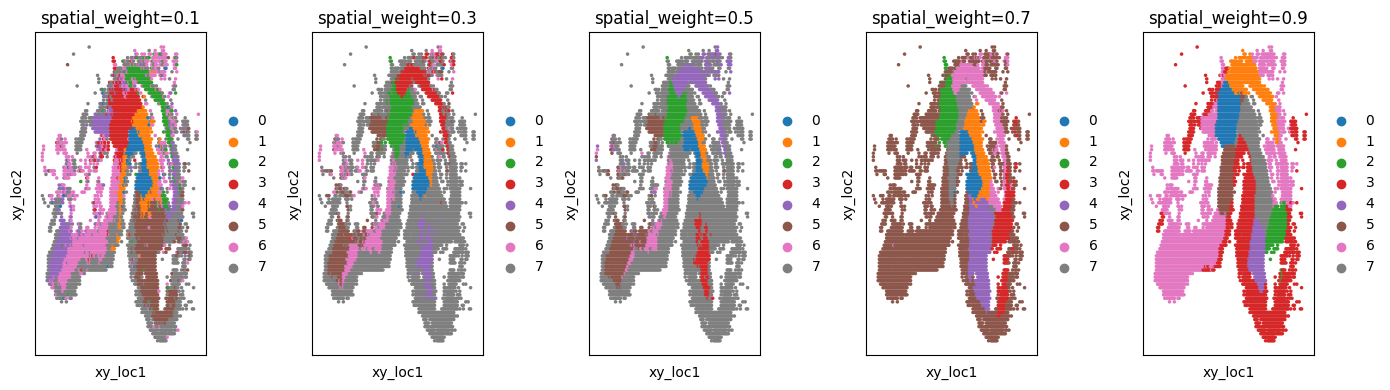

In [20]:
import matplotlib.pyplot as plt
adata.obs['attractor'] = adata.obs['Region']
sc.pp.neighbors(adata, use_rep = 'xy_loc',key_added ='spatial')
nrows =1
weights = [0.1,0.3,0.5,0.7,0.9]
ncols = len(weights)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4))

for i,sw in enumerate(weights):
#adata.obsm['X_umap'] = adata_aggr.obsm['X_umap']
    adata_aggr = st.tl.dynamical_iteration(adata,n_states =8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 100,thresh_ms_gene = 0.2, use_spatial = True,spa_weight = sw, thresh_entropy = 0.1)    
    ax = axes[i]
    sc.pl.embedding(adata, basis="xy_loc", color="attractor",show = False, ax = ax)
    ax.set_title('spatial_weight='+str(sw))
plt.tight_layout()
plt.show()

                            

### Sensitivity on Initial Condition

In [21]:
adata.obs['spa_leiden']=adata.obs['leiden']

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999512e-01 1.4467731033366722e-02 9.0500934269056778e-03 2.7357875525306122e-02 2.0613901069744114e-02 2.3776476059850563e-02 -1.6251812897883550e-02 -8.2762598335691228e-03 -2.3312433970186057e-02 -1.8371566332631675e-02 -5.3297447808749792e-03 5.0262265991480384e-03 -1.3960285131265034e-03 -2.9337984962928138e-03 -9.6734034104829017e-03 3.8605985597971937e-03 9.8476165745965214e-03 -4.2922777718067199e-05 5.1780032368692617e-03 -4.2397933614465866e-02 -1.8626778698929496e-04 2.6325833669625111e-03 
0.0000000000000000e+00 9.3647583786828725e-01 6.0525825331141187e-03 7.6887503008938171e-03 9.0792753773203446e-03 8.5523758672056624e-04 3.1963702290322151e-03 -8.7905400140356679e-03 -2.5248834849948090e-03 -8.8174187322229269e-03 -8.0741349873159139e-04 -4.8788774039995285e-03 -1.6159635392824213e-02 -1.4475527746312593e-03 -9.3853358694685283e-03 7.7330121246530796e-03 -5.0419168175648631e-04 2.5214087554821418e-03 -1.34853992131

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000069e+00 -1.2826527079421028e-02 -3.2097126420181014e-03 -2.2098425399901679e-02 2.0138996872463913e-02 -8.7229250128443483e-03 2.2520463705527329e-02 5.0524699068834984e-03 2.2625993053379976e-03 -6.3118851427153861e-03 1.5595058765201649e-02 1.3041924200923255e-02 1.4817555441004328e-02 -4.4357023279734386e-04 -5.9157206726901520e-03 1.1315296299293010e-02 -8.9884650876533578e-03 -1.0586644354879736e-02 -2.7008004219549568e-03 -1.3992266399937048e-02 -5.1614703089394509e-03 -4.2250643227475411e-02 
0.0000000000000000e+00 9.3754170407069015e-01 3.9539391727891129e-03 7.7123107111253895e-03 -6.4733752373709718e-03 -6.9287894198291570e-03 -7.0730433507607828e-04 -7.6607049769186952e-03 4.3644266977748399e-03 1.9563529991736407e-03 -2.2750058489821334e-03 -1.0704220031086461e-03 -6.6625324943970820e-03 1.2939203888092679e-02 6.8845220109938271e-03 -4.9376566797462397e-03 -8.5921938774000551e-03 8.3132849193245685e-03 3.3708583067

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000013e+00 -8.1049743842675631e-03 9.3025430426457740e-03 -1.7070039230932189e-02 2.6051709666416730e-02 1.4970090463794937e-02 1.3165366244158478e-02 1.1459414339417436e-02 1.6792971157640606e-02 9.2133972905688588e-03 -2.2003201996901568e-02 -2.7821516690140040e-03 -3.3508141213867463e-03 5.1047076175236659e-03 -1.2340332408208339e-02 -8.2461812106538503e-03 8.1513586669583228e-03 2.7111644896835119e-03 -1.6312032851432692e-02 -2.0355797792075834e-02 -3.0029079765860250e-02 3.1116705467807790e-03 
0.0000000000000000e+00 9.4791075498055266e-01 -4.7330871685025899e-03 5.4316995538254420e-03 -8.1933556606280707e-03 5.7429290745526825e-03 4.5072133453030062e-03 1.0438982815790608e-03 -4.6240673820611092e-03 -6.3626135818810959e-03 6.1102091415636620e-03 -1.7977575982822988e-03 -1.2841873567513257e-02 -3.7201772910031572e-03 1.3570452441383319e-02 -6.3811565608494828e-04 -1.8231115744993215e-03 7.6143875962230642e-03 2.3564911435223

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


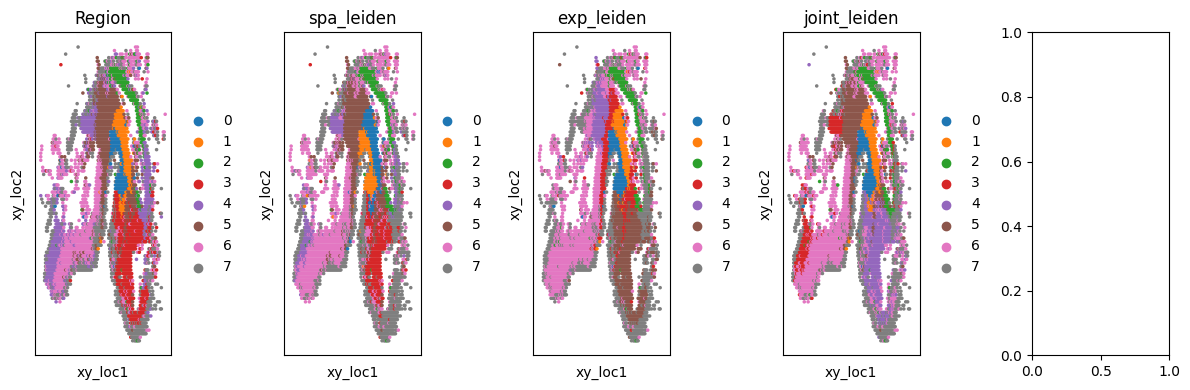

In [22]:
init_key = ['Region','spa_leiden','exp_leiden','joint_leiden']
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))
for i,key in enumerate(init_key):
    adata.obs['attractor'] = adata.obs[key]
    adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
    ax = axes[i]
    sc.pl.embedding(adata, basis="xy_loc", color="attractor",show = False, ax = ax)
    ax.set_title(key)
plt.tight_layout()
plt.show()

### Sensitivity on MS score filter

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


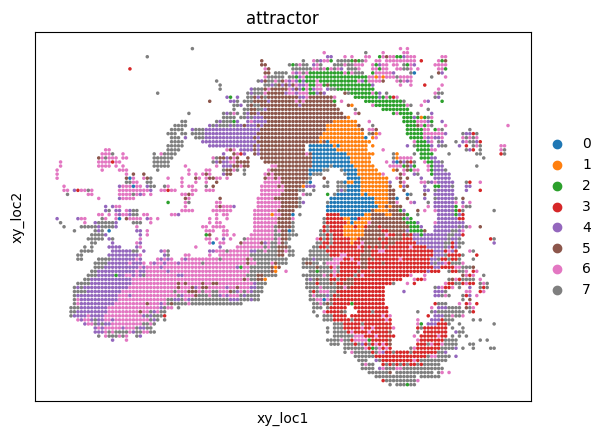

AnnData object with n_obs × n_vars = 4628 × 190
    obs: 'entropy', 'attractor', 'speed'
    var: 'highly_variable'
    uns: 'pca', 'neighbors', 'T_fwd_params', 'eig_fwd', 'gene_subset'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'velocity', 'spliced', 'Ms', 'vj'
    obsp: 'distances', 'connectivities', 'T_fwd'

In [23]:
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")
adata_aggr

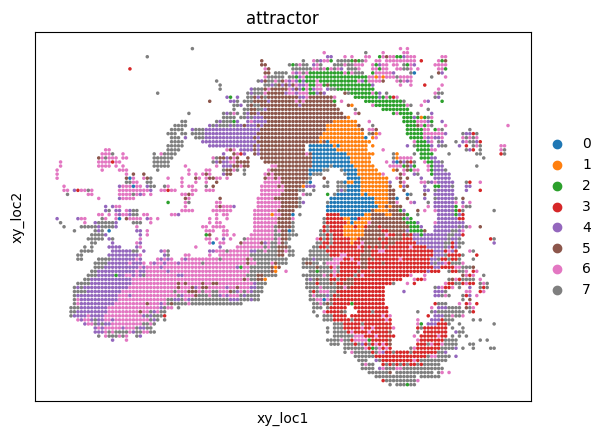

In [24]:
sc.pl.embedding(adata, basis="xy_loc", color="attractor")

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)


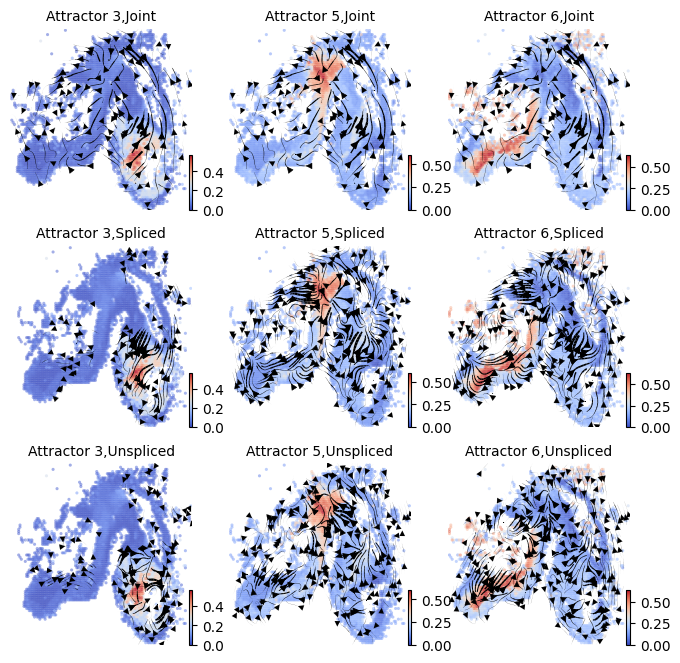

In [25]:
adata.obsm['X_xy_loc'] = adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
adata.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
st.pl.plot_tensor(adata, adata_aggr, list_attractor = [3,5,6],basis = 'xy_loc',filter_cells = True, member_thresh = 0.1, density = 1)


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999301e-01 8.1788327953175271e-04 -1.9069462087982596e-02 5.9271162832497972e-04 -1.3172804275442915e-02 -3.3768614640669770e-02 2.6858492672894793e-02 1.1880163748275647e-02 2.0492171429346354e-02 2.0666741422174586e-02 1.7877834726645753e-02 -1.1683128036229978e-02 -5.6475515322144325e-04 2.0226391600456178e-02 1.1870261720784132e-02 2.7814620049354984e-02 1.1455613224717682e-02 -1.1326177451571327e-02 -3.6444994531943720e-03 1.3411963684027476e-02 2.3073837308802931e-02 -6.0441780478301281e-02 
0.0000000000000000e+00 9.6577288051851629e-01 1.7707168973524813e-03 -5.4764414611868078e-03 1.8643703854715630e-03 -2.4647677326673847e-03 3.2713257457163119e-03 -1.4165938097824936e-04 1.6836904328078363e-02 2.0530012810618808e-03 8.7138937933305058e-03 2.5853530934015169e-03 1.2798628338440759e-03 9.5416793825992934e-03 6.8286906115490624e-04 -8.3869660194786644e-03 -8.2655340138101177e-03 3.4660971573502002e-03 -3.4947416362626632e-

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


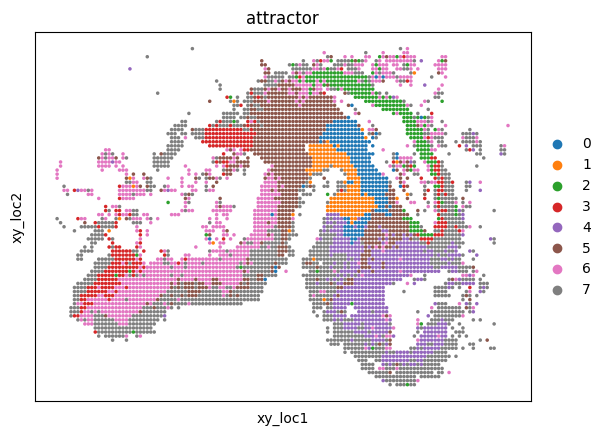

In [26]:
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.3, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:07) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)


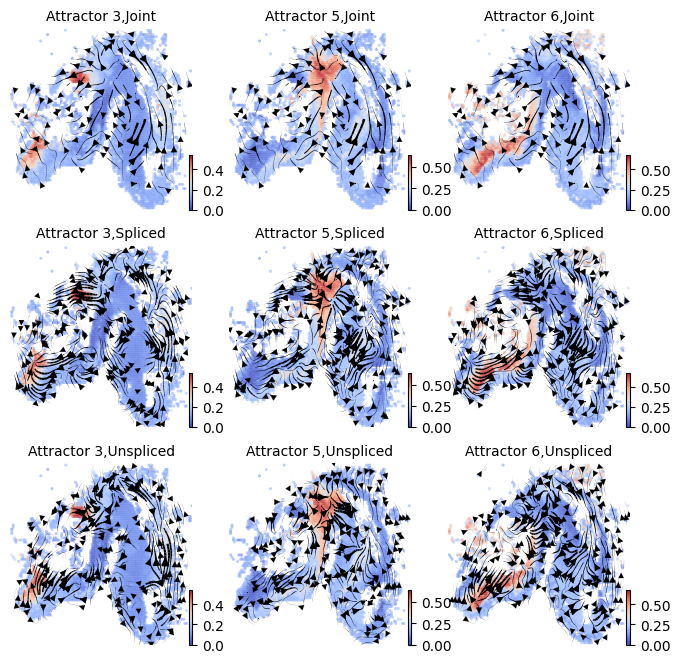

In [27]:
adata.obsm['X_xy_loc'] = adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
adata.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
st.pl.plot_tensor(adata, adata_aggr, list_attractor = [3,5,6],basis = 'xy_loc',filter_cells = True, member_thresh = 0.1, density = 1)


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999922e-01 2.4648548704155446e-03 1.2418403392769806e-02 -5.2460083172528428e-03 -2.8464259225905553e-02 2.4780400127018286e-02 1.1672298340494035e-02 -7.0399322967106741e-04 -1.7931384288720757e-02 1.7087176942316786e-02 -9.5869336209622423e-03 -1.2993844651612834e-03 2.0772838094440027e-02 2.5378758383074882e-02 1.6902786557392722e-02 7.8718085737514744e-03 -1.6454382410131727e-02 1.3652976659121165e-02 -1.9713038107247855e-02 3.7733014447488264e-02 -4.7892736738010873e-04 -4.5233701228307298e-02 2.9685557253147161e-02 -3.0625062999288064e-02 
0.0000000000000000e+00 9.6132972188031485e-01 5.7744616030606022e-04 -2.6404855461659212e-03 -1.6435721524854271e-03 3.4693507907816992e-03 3.2138118259799112e-03 -3.9129043339003605e-03 -1.4935491735041084e-02 -2.9637972597509193e-04 -4.5665962111169260e-03 1.4638659445456923e-04 5.8859780609619378e-03 1.7174955001789200e-04 3.8448985475197505e-04 -1.4623454526417060e-02 -3.9730099161659

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


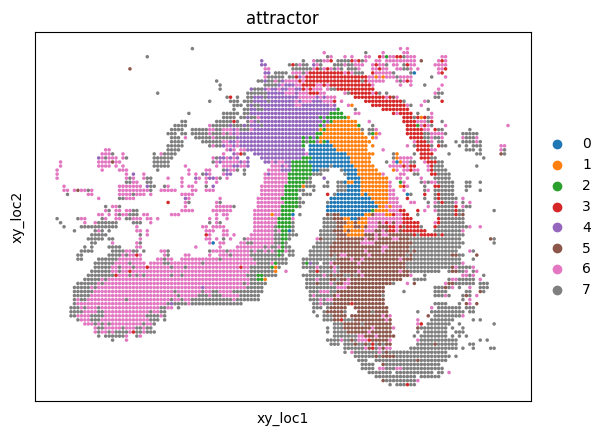

AnnData object with n_obs × n_vars = 4628 × 200
    obs: 'entropy', 'attractor', 'speed'
    var: 'highly_variable'
    uns: 'pca', 'neighbors', 'T_fwd_params', 'eig_fwd', 'gene_subset'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'velocity', 'spliced', 'Ms', 'vj'
    obsp: 'distances', 'connectivities', 'T_fwd'

In [28]:
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.1, spa_weight =0.1, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")
adata_aggr

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:06) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:07) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)


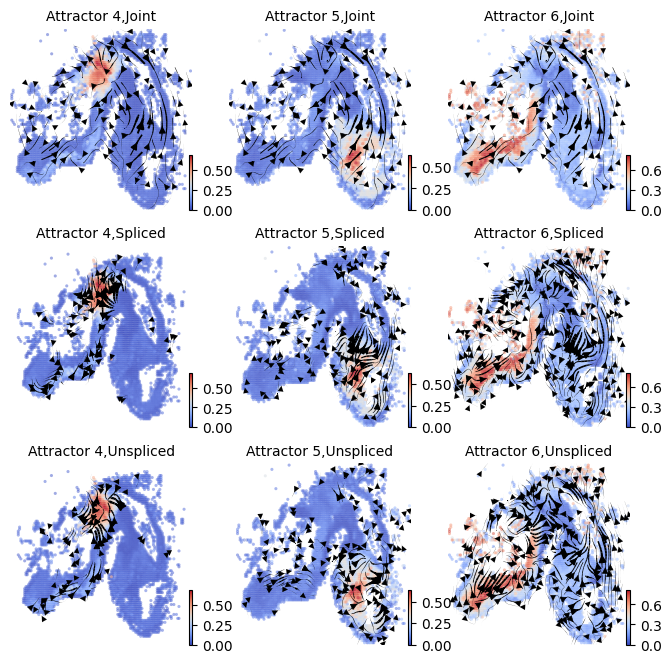

In [29]:
adata.obsm['X_xy_loc'] = adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
adata_aggr.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
adata.obsm['X_xy_loc_aggr']=adata.obsm['xy_loc']
st.pl.plot_tensor(adata, adata_aggr, list_attractor = [4,5,6],basis = 'xy_loc',filter_cells = True, member_thresh = 0.1, density = 1)


### Number of attractors

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


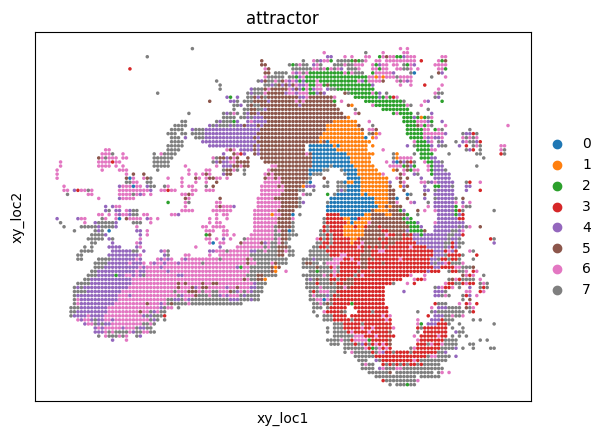

In [30]:
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 8, n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")

computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


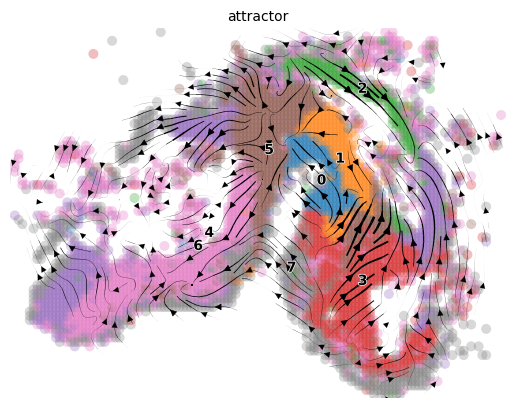

In [31]:
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
scv.tl.velocity_graph(adata_aggr,n_jobs=-1,vkey = 'vj')
scv.pl.velocity_embedding_stream(adata_aggr, basis='xy_loc', color='attractor',vkey = 'vj',density = 2)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


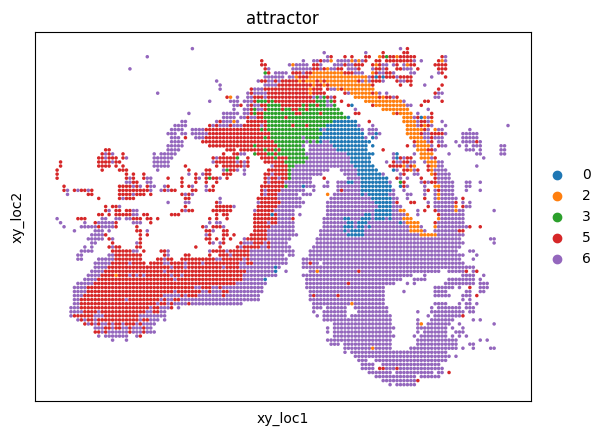

computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


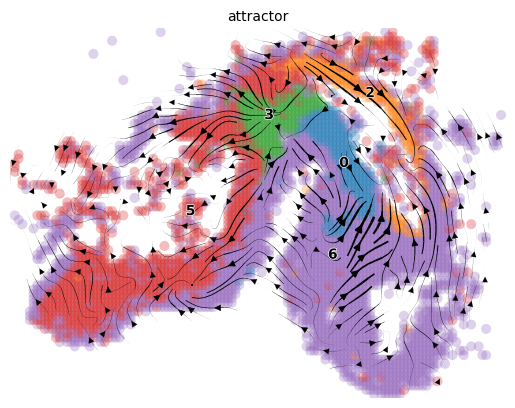

In [32]:
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 7 , n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
scv.tl.velocity_graph(adata_aggr,n_jobs=-1,vkey = 'vj')
scv.pl.velocity_embedding_stream(adata_aggr, basis='xy_loc', color='attractor',vkey = 'vj',density = 2)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


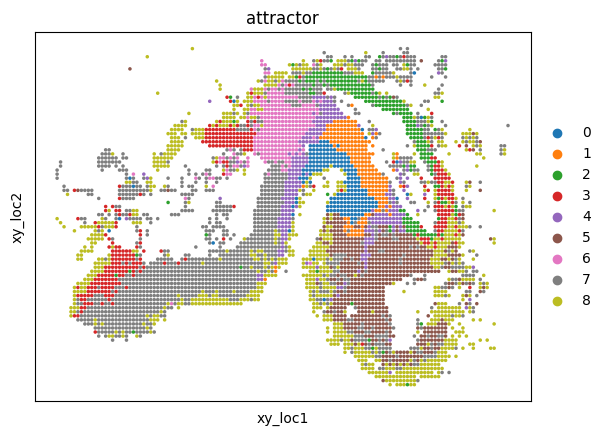

computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


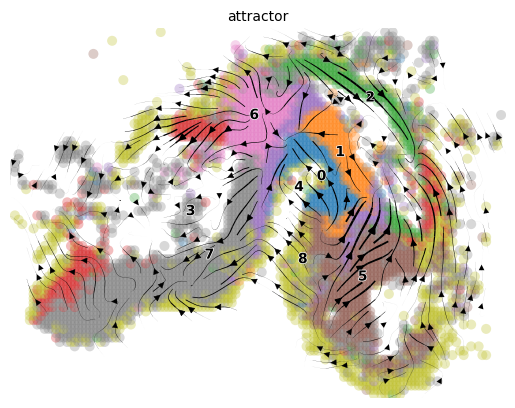

In [33]:
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 9 , n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
scv.tl.velocity_graph(adata_aggr,n_jobs=-1,vkey = 'vj')
scv.pl.velocity_embedding_stream(adata_aggr, basis='xy_loc', color='attractor',vkey = 'vj',density = 2)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000000e+00 -2.4831054436749943e-02 1.7756018087547558e-03 2.3657390960549293e-02 2.2033536194653612e-02 3.5394505418939307e-03 6.9996242894230466e-03 -3.6814826653680096e-03 3.5815619230925709e-02 -8.9081962490976038e-03 -1.9690108158494691e-02 -3.9554038369697224e-03 5.5300566789621029e-03 5.4571288343809414e-03 9.0436821307113627e-03 8.8535613259629990e-03 -1.4356950629733434e-02 -6.9938898940196436e-03 5.3617024493116715e-03 -2.5244578225412380e-02 -2.8287466684097737e-02 5.7708113029352318e-02 
0.0000000000000000e+00 9.1886345758917398e-01 -4.9514399251172582e-03 1.6433507448793442e-03 -1.0230970416201772e-02 7.6129879933227668e-04 1.6462171332775458e-02 -3.4252656083655435e-03 -3.9678921723149997e-03 8.5801617324925573e-03 1.8928510927774195e-03 3.9882486417770399e-04 -1.4095972628097234e-02 -1.7707882269979682e-02 -9.2902831987297341e-04 6.3720258815207177e-04 -4.3356743865847255e-03 -6.9768218367936867e-03 -1.5287972234285

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


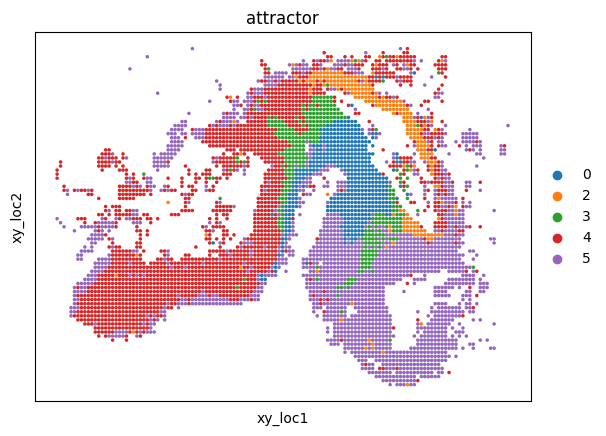

computing velocity graph (using 16/16 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


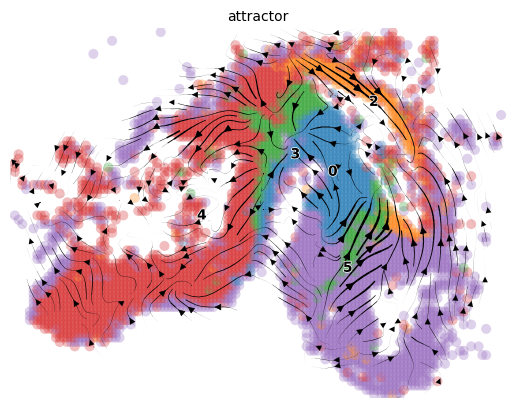

In [34]:
adata.obs['attractor'] = adata.obs['Region']
adata_aggr = st.tl.dynamical_iteration(adata,n_states = 6 , n_iter = 15, weight_connectivities = 0.5,n_components = 21, n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3, thresh_entropy = 0.1)
sc.pl.embedding(adata, basis="xy_loc", color="attractor")
adata_aggr.obsm['X_xy_loc']=adata.obsm['xy_loc']
scv.tl.velocity_graph(adata_aggr,n_jobs=-1,vkey = 'vj')
scv.pl.velocity_embedding_stream(adata_aggr, basis='xy_loc', color='attractor',vkey = 'vj',density = 2)